In [ ]:
# predict the IDR cluster label for a new IDR instance
## method1: based on minimum distance with clustered instances;
## method2: predict with fetaures (multi-classification)

In [1]:
import numpy as np
import pandas as pd
import os, sys
import pickle as pkl
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier  # multi:softmax or multi:softprob
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'

### data preparation

In [2]:
# load data:
## golden standard: whole clustering results
## raw features & normalized features
raw_features_df = pd.read_csv('./data/IDR/All_PS_target_IDR_info_30_1000_5%_DisProt_Predicted.csv')[[
    'IDR_ID', 'gene_name', 'DE_RHK_deltazscore', 'acid_fraction', 'basic_fraction', 
    'hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction'
]]
# print(raw_features_df.shape)  # Sample: 202 instances

# raw_features_df.head(2)
normalized_features_df = pd.read_csv('./data/IDR/NewCluster/clustered_pro_info_df.csv')[[
    'gene_name', 'DE_RHK_deltazscore', 'acid_fraction', 'basic_fraction', 
    'hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction'
]]
# normalized_features_df.head(2)
# make the order of raw and normalized be the same
normalized_features_df = normalized_features_df.set_index(keys='gene_name')
normalized_features_df = normalized_features_df.loc[raw_features_df.gene_name.tolist()]
assert raw_features_df.gene_name.tolist() == normalized_features_df.index.tolist()

## labels
nonpolar_pros = pd.read_csv('./data/IDR/NewCluster/nonpolar_protein_info.csv')['gene_name'].tolist()
hydrophilic_pros = pd.read_csv('./data/IDR/NewCluster/hydrophilic_protein_info.csv')['gene_name'].tolist()
pos_neg_pros = pd.read_csv('./data/IDR/NewCluster/pos_neg_block_protein_info.csv')['gene_name'].tolist()

labels = []
for gene in raw_features_df.gene_name.tolist():
    if gene in nonpolar_pros:
        labels.append(1)
    elif gene in hydrophilic_pros:
        labels.append(2)
    # elif gene in pos_neg_pros:
    #     labels.append(3)
    else:
        labels.append(0)

# data
# raw_features = raw_features_df[['DE_RHK_deltazscore', 'acid_fraction', 'basic_fraction', 
#                                 'hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction']].values
# normalized_features = normalized_features_df[['DE_RHK_deltazscore', 'acid_fraction', 'basic_fraction', 
#                                               'hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction']].values
raw_features = raw_features_df[['acid_fraction', 'basic_fraction', 
                                'hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction']].values
normalized_features = normalized_features_df[['acid_fraction', 'basic_fraction', 
                                              'hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction']].values
labels = np.array(labels, dtype=np.int64)

raw_features.shape, normalized_features.shape, labels.shape

((202, 5), (202, 5), (202,))

### train test split: 5-cv

In [3]:
# 5-cv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# train_index_list, test_index_list = [], []
train_test_data_dict = {}

for i, (train_index, test_index) in enumerate(skf.split(raw_features, labels)):
    print(f'-------fold{i}--------')
    train_raw_features = raw_features[train_index]
    test_raw_features = raw_features[test_index]
    train_normalized_features = normalized_features[train_index]
    test_normalized_features = normalized_features[test_index]
    test_labels = labels[test_index]

    # print(train_index)
    # print(test_index)
    # # break
    # train_index_list.append(train_index)
    # test_index_list.append(test_index)

    # clustering for each fold: get labels for train data
    train_data = normalized_features_df.iloc[train_index, :]
    # two level clustering
    noncharge_part = train_data[(train_data.acid_fraction < 0.3) & (train_data.basic_fraction < 0.3)]
    charge_part = train_data[(train_data.acid_fraction >= 0.3) | (train_data.basic_fraction >= 0.3)]
    print('noncharge v.s. charge:', noncharge_part.shape, charge_part.shape)
    
    noncharge_features = ['hydrophilic_fraction', 'nonpolar_fraction', 'aromatic_fraction',]
    noncharge_feat_norm_df = noncharge_part[noncharge_features]
    clust_labels = AgglomerativeClustering(
        distance_threshold=0.9, n_clusters=None, affinity='cosine', 
        linkage='average').fit_predict(noncharge_feat_norm_df.values)
    print('noncharge cluster labels:', set(clust_labels))
    # row_colors = [sns.color_palette('Set3', 13)[f+2] for f in clust_labels]
    # noncharge_grid = sns.clustermap(noncharge_feat_norm_df, cmap='YlGnBu_r', metric='cosine',
    #                       row_colors=row_colors, cbar_kws={'label': 'z-score'}, figsize=(3, 6)) # ,col_cluster=False
    # plt.setp(noncharge_grid.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    # plt.show()
    nonpolar_clusts = []
    for gene in ['ESR1', 'PGR', 'SRC', 'MAPT', 'AR', 'ERBB2', 'SFPQ', 'SMAD3']:
        if gene in noncharge_part.index.tolist():
            tmp = clust_labels[noncharge_part.index.tolist().index(gene)]
            nonpolar_clusts.append(tmp)
    nonpolar_clusts = list(set(nonpolar_clusts))
    print('nonpolar labels:', nonpolar_clusts)
    # get nonpolar pros(train set)
    train_nonpolar_pros = []
    for c in nonpolar_clusts:
        train_nonpolar_pros += noncharge_part.index[np.arange(len(noncharge_part))[clust_labels == c]].tolist()

    hydro_clusts = []
    for gene in ['BRAF', 'NR3C1', 'RAF1']:
        if gene in noncharge_part.index.tolist():
            tmp = clust_labels[noncharge_part.index.tolist().index(gene)]
            hydro_clusts.append(tmp)
    hydro_clusts = list(set(hydro_clusts))
    print('hydrophilic labels:', hydro_clusts)
    # get nonpolar pros(train set)
    train_hydro_pros = []
    for c in hydro_clusts:
        train_hydro_pros += noncharge_part.index[np.arange(len(noncharge_part))[clust_labels == c]].tolist()

    charge_features = ['acid_fraction', 'basic_fraction', 'DE_RHK_deltazscore']
    charge_feat_norm_df = charge_part[charge_features]
    clust_labels = AgglomerativeClustering(
        distance_threshold=0.9, n_clusters=None, affinity='cosine', 
        linkage='average').fit_predict(charge_feat_norm_df.values)
    # row_colors = [sns.color_palette('Set3', 13)[f+2] for f in clust_labels]
    # charge_grid = sns.clustermap(charge_feat_norm_df, cmap='YlGnBu_r', metric='cosine',
    #                       row_colors=row_colors, cbar_kws={'label': 'z-score'}, figsize=(3.5, 7))
    # plt.setp(charge_grid.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    # plt.show()
    print('charge cluster labels:', set(clust_labels))
    pos_neg_clusts = []
    for gene in ['BIRC5', 'TOP2A', 'TOP2B', 'NPM1', 'CALR']:
        if gene in charge_part.index.tolist():
            tmp = clust_labels[charge_part.index.tolist().index(gene)]
            pos_neg_clusts.append(tmp)
    pos_neg_clusts = list(set(pos_neg_clusts))
    print('pos/neg labels:', pos_neg_clusts)

    train_pos_neg_pros = []
    for c in pos_neg_clusts:
        train_pos_neg_pros += charge_part.index[np.arange(len(charge_part))[clust_labels == c]].tolist()

    print('nonpolar v.s. hydrophilic v.s. pos/neg:', len(train_nonpolar_pros), len(train_hydro_pros), len(train_pos_neg_pros))

    train_labels = []
    for pro in train_data.index.tolist():
        if pro in train_nonpolar_pros:
            train_labels.append(1)
        elif pro in train_hydro_pros:
            train_labels.append(2)
        # elif pro in train_pos_neg_pros:
        #     train_labels.append(3)
        else:
            train_labels.append(0)
    train_labels = np.array(train_labels, dtype=np.int64)

    # save splitted data
    train_test_data_dict[f'fold{i}'] = (train_index, test_index, train_raw_features, test_raw_features,
                                        train_normalized_features, test_normalized_features, train_labels, test_labels)

-------fold0--------
noncharge v.s. charge: (75, 6) (86, 6)
noncharge cluster labels: {0, 1, 2}
nonpolar labels: [0, 1]
hydrophilic labels: [2]
charge cluster labels: {0, 1, 2}
pos/neg labels: [2]
nonpolar v.s. hydrophilic v.s. pos/neg: 41 34 16
-------fold1--------
noncharge v.s. charge: (75, 6) (86, 6)
noncharge cluster labels: {0, 1, 2}
nonpolar labels: [0, 1]
hydrophilic labels: [2]
charge cluster labels: {0, 1, 2}
pos/neg labels: [2]
nonpolar v.s. hydrophilic v.s. pos/neg: 43 32 22
-------fold2--------
noncharge v.s. charge: (76, 6) (86, 6)
noncharge cluster labels: {0, 1, 2}
nonpolar labels: [0]
hydrophilic labels: [2]
charge cluster labels: {0, 1, 2}
pos/neg labels: [0]
nonpolar v.s. hydrophilic v.s. pos/neg: 38 33 33
-------fold3--------
noncharge v.s. charge: (75, 6) (87, 6)
noncharge cluster labels: {0, 1}
nonpolar labels: [0]
hydrophilic labels: [1]
charge cluster labels: {0, 1, 2}
pos/neg labels: [1]
nonpolar v.s. hydrophilic v.s. pos/neg: 42 33 26
-------fold4--------
nonc

### Random forest multi-classification

In [4]:
rf_raw_results, rf_norm_results = {}, {}

for fold, (_, _, train_raw_X, test_raw_X, train_norm_X, test_norm_X, train_y, test_y) in train_test_data_dict.items():
    print(fold,':')
    # using raw features
    rf = RandomForestClassifier(random_state=42, class_weight=None, n_estimators=100)
    rf.fit(train_raw_X, train_y)
    # predict
    test_preds = rf.predict(test_raw_X)
    # print(test_y, test_preds)
    acc = balanced_accuracy_score(test_y, test_preds)
    pre = precision_score(test_y, test_preds, average='weighted')
    rec = recall_score(test_y, test_preds, average='weighted')
    conf_mat = confusion_matrix(test_y, test_preds)
    print(acc, pre, rec)
    rf_raw_results[fold] = (acc, pre, rec)
    # print(conf_mat)

    rf2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=None)
    rf2.fit(train_norm_X, train_y)
    # predict
    test_preds2 = rf2.predict(test_norm_X)
    acc2 = balanced_accuracy_score(test_y, test_preds2)
    pre2 = precision_score(test_y, test_preds2, average='weighted')
    rec2 = recall_score(test_y, test_preds2, average='weighted')
    conf_mat2 = confusion_matrix(test_y, test_preds2)
    print(acc2, pre2, rec2)
    rf_norm_results[fold] = (acc2, pre2, rec2)
    # print(conf_mat2)
    # break
    
rf_raw_accs = [acc for acc, _, _ in rf_raw_results.values()]
rf_raw_pres = [pre for _, pre, _ in rf_raw_results.values()]
rf_raw_recs = [rec for _, _, rec in rf_raw_results.values()]

rf_norm_accs = [acc for acc, _, _ in rf_norm_results.values()]
rf_norm_pres = [pre for _, pre, _ in rf_norm_results.values()]
rf_norm_recs = [rec for _, _, rec in rf_norm_results.values()]
print('Raw features=====')
print(f'Balanced accuracy: {np.mean(rf_raw_accs):.4f} ± {np.std(rf_raw_accs):.4f}')
print(f'Precision: {np.mean(rf_raw_pres):.4f} ± {np.std(rf_raw_pres):.4f}')
print(f'Recall: {np.mean(rf_raw_recs):.4f} ± {np.std(rf_raw_recs):.4f}')
print('Norm features=====')
print(f'Balanced accuracy: {np.mean(rf_norm_accs):.4f} ± {np.std(rf_norm_accs):.4f}')
print(f'Precision: {np.mean(rf_norm_pres):.4f} ± {np.std(rf_norm_pres):.4f}')
print(f'Recall: {np.mean(rf_norm_recs):.4f} ± {np.std(rf_norm_recs):.4f}')

fold0 :
0.9583333333333334 0.9776422764227641 0.975609756097561
0.9583333333333334 0.9776422764227641 0.975609756097561
fold1 :
0.8888888888888888 0.9437148217636023 0.926829268292683
0.8888888888888888 0.9437148217636023 0.926829268292683
fold2 :
0.9333333333333332 0.96 0.95
0.9666666666666667 0.9777777777777779 0.975
fold3 :
0.9515151515151515 0.9527777777777778 0.95
0.9515151515151515 0.9527777777777778 0.95
fold4 :
0.9696969696969697 0.9777777777777779 0.975
0.9696969696969697 0.9777777777777779 0.975
Raw features=====
Balanced accuracy: 0.9404 ± 0.0283
Precision: 0.9624 ± 0.0135
Recall: 0.9555 ± 0.0183
Norm features=====
Balanced accuracy: 0.9470 ± 0.0298
Precision: 0.9659 ± 0.0147
Recall: 0.9605 ± 0.0195


### Cosine distance classifier

In [19]:
# def CosineDistance(x, y):
#     """
#     x: m * k array;
#     y: n * k array;
#     return: m * n array
#     """
#     xx = np.sum(x ** 2, axis=1) ** 0.5
#     yy = np.sum(y ** 2, axis=1) ** 0.5
#     x = x / xx[:, np.newaxis]
#     y = y / yy[:, np.newaxis]
#     dist = 1 - np.dot(x, y.transpose())
#     return dist
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

cos_raw_results, cos_norm_results = {}, {}
euc_raw_results, euc_norm_results = {}, {}

for fold, (_, _, train_raw_X, test_raw_X, train_norm_X, test_norm_X, train_y, test_y) in train_test_data_dict.items():
    print(fold, ':')
    # minimum cosine distance (OvO)
    raw_cos_dis_mat = cosine_distances(train_raw_X, test_raw_X)
    # minimum distance
    min_dis_indices = np.argmin(raw_cos_dis_mat, axis=0)
    test_preds = np.array([train_y[ind] for ind in min_dis_indices], dtype=np.int64)
    acc = balanced_accuracy_score(test_y, test_preds)
    pre = precision_score(test_y, test_preds, average='weighted')
    rec = recall_score(test_y, test_preds, average='weighted')
    print(acc, pre, rec)
    cos_raw_results[fold] = (acc, pre, rec)

    # minimum cosine distance (OvO, normalized features)
    norm_cos_dis_mat = cosine_distances(train_norm_X, test_norm_X)
    # minimum distance
    min_dis_indices = np.argmin(norm_cos_dis_mat, axis=0)
    test_preds = np.array([train_y[ind] for ind in min_dis_indices], dtype=np.int64)
    acc = balanced_accuracy_score(test_y, test_preds)
    pre = precision_score(test_y, test_preds, average='weighted')
    rec = recall_score(test_y, test_preds, average='weighted')
    print(acc, pre, rec)
    cos_norm_results[fold] = (acc, pre, rec)
    
    # # minimum euclidean distance (OvO, normalized features)
    raw_euc_dis_mat = euclidean_distances(train_raw_X, test_raw_X)
    # minimum distance
    min_dis_indices = np.argmin(raw_euc_dis_mat, axis=0)
    test_preds = np.array([train_y[ind] for ind in min_dis_indices], dtype=np.int64)
    acc = balanced_accuracy_score(test_y, test_preds)
    pre = precision_score(test_y, test_preds, average='weighted')
    rec = recall_score(test_y, test_preds, average='weighted')
    print(acc, pre, rec)
    euc_raw_results[fold] = (acc, pre, rec)

    # # minimum euclidean distance (OvO, normalized features)
    norm_euc_dis_mat = euclidean_distances(train_norm_X, test_norm_X)
    # minimum distance
    min_dis_indices = np.argmin(norm_euc_dis_mat, axis=0)
    test_preds = np.array([train_y[ind] for ind in min_dis_indices], dtype=np.int64)
    acc = balanced_accuracy_score(test_y, test_preds)
    pre = precision_score(test_y, test_preds, average='weighted')
    rec = recall_score(test_y, test_preds, average='weighted')
    print(acc, pre, rec)
    euc_norm_results[fold] = (acc, pre, rec)

    # # minimum manhattan distance
    # norm_man_dis_mat = manhattan_distances(train_norm_X, test_norm_X)
    # # minimum distance
    # min_dis_indices = np.argmin(norm_man_dis_mat, axis=0)
    # test_preds = np.array([train_y[ind] for ind in min_dis_indices], dtype=np.int64)
    # acc = balanced_accuracy_score(test_y, test_preds)
    # print(acc)

fold0 :
0.7916666666666666 0.8048780487804879 0.8048780487804879
0.8787878787878788 0.8758807588075881 0.8780487804878049
0.8068181818181818 0.8251325556733827 0.8292682926829268
0.7765151515151515 0.7967479674796749 0.8048780487804879
fold1 :
0.673063973063973 0.7370731707317073 0.7317073170731707
0.8629629629629628 0.9174484052532832 0.9024390243902439
0.6882154882154882 0.7582864290181364 0.7560975609756098
0.7804713804713804 0.815040650406504 0.8048780487804879
fold2 :
0.806060606060606 0.805 0.8
0.8878787878787878 0.8794372294372295 0.875
0.7727272727272728 0.7793434343434343 0.775
0.8545454545454545 0.8520634920634921 0.85
fold3 :
0.8212121212121213 0.8347402597402598 0.825
0.903030303030303 0.9 0.9
0.806060606060606 0.8043831168831168 0.8
0.756060606060606 0.7768633540372671 0.775
fold4 :
0.850108225108225 0.8890350877192983 0.85
0.8917748917748917 0.8800000000000001 0.875
0.8917748917748917 0.923076923076923 0.875
0.8614718614718614 0.8808333333333334 0.85


In [20]:
rf_raw_accs = [acc for acc, _, _ in rf_raw_results.values()]
rf_raw_pres = [pre for _, pre, _ in rf_raw_results.values()]
rf_raw_recs = [rec for _, _, rec in rf_raw_results.values()]

rf_norm_accs = [acc for acc, _, _ in rf_norm_results.values()]
rf_norm_pres = [pre for _, pre, _ in rf_norm_results.values()]
rf_norm_recs = [rec for _, _, rec in rf_norm_results.values()]

cos_raw_accs = [acc for acc, _, _ in cos_raw_results.values()]
cos_raw_pres = [pre for _, pre, _ in cos_raw_results.values()]
cos_raw_recs = [rec for _, _, rec in cos_raw_results.values()]

cos_norm_accs = [acc for acc, _, _ in cos_norm_results.values()]
cos_norm_pres = [pre for _, pre, _ in cos_norm_results.values()]
cos_norm_recs = [rec for _, _, rec in cos_norm_results.values()]

euc_raw_accs = [acc for acc, _, _ in euc_raw_results.values()]
euc_raw_pres = [pre for _, pre, _ in euc_raw_results.values()]
euc_raw_recs = [rec for _, _, rec in euc_raw_results.values()]

euc_norm_accs = [acc for acc, _, _ in euc_norm_results.values()]
euc_norm_pres = [pre for _, pre, _ in euc_norm_results.values()]
euc_norm_recs = [rec for _, _, rec in euc_norm_results.values()]

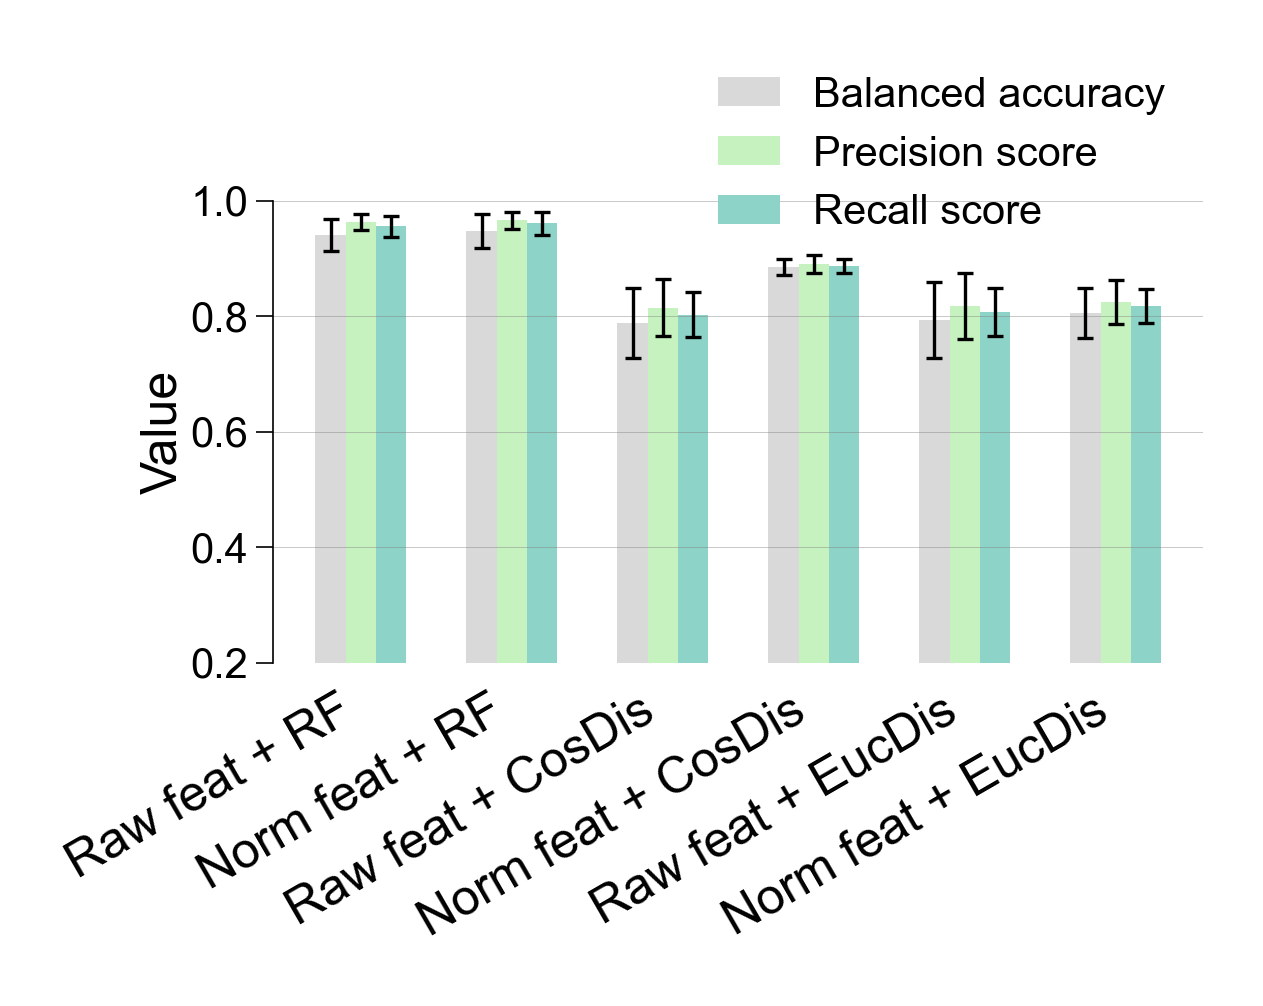

In [21]:
# balanced accuracy
fig, ax = plt.subplots(1, 1, dpi=600, figsize=(2, 1))
for h in [0.2, 0.4, 0.6, 0.8, 1.]:
    ax.axhline(h, color="#7F7F7F", alpha=0.5, linewidth=0.1, linestyle='-')
xs = np.array([0, 1, 2, 3, 4, 5])
mean_acc_list = [np.mean(rf_raw_accs), np.mean(rf_norm_accs), np.mean(cos_raw_accs),
                 np.mean(cos_norm_accs), np.mean(euc_raw_accs), np.mean(euc_norm_accs)]
std_acc_list = [np.std(rf_raw_accs), np.std(rf_norm_accs), np.std(cos_raw_accs),
                np.std(cos_norm_accs), np.std(euc_raw_accs), np.std(euc_norm_accs)]
mean_pre_list = [np.mean(rf_raw_pres), np.mean(rf_norm_pres), np.mean(cos_raw_pres),
                 np.mean(cos_norm_pres), np.mean(euc_raw_pres), np.mean(euc_norm_pres)]
std_pre_list = [np.std(rf_raw_pres), np.std(rf_norm_pres), np.std(cos_raw_pres),
                np.std(cos_norm_pres), np.std(euc_raw_pres), np.std(euc_norm_pres)]
mean_rec_list = [np.mean(rf_raw_recs), np.mean(rf_norm_recs), np.mean(cos_raw_recs),
                 np.mean(cos_norm_recs), np.mean(euc_raw_recs), np.mean(euc_norm_recs)]
std_rec_list = [np.std(rf_raw_recs), np.std(rf_norm_recs), np.std(cos_raw_recs),
                np.std(cos_norm_recs), np.std(euc_raw_recs), np.std(euc_norm_recs)]
err_attrs = {"elinewidth":0.4, "ecolor":"black", "capsize":1, 'capthick': 0.4}
width=0.2
ax.bar(xs-width, mean_acc_list, width=width, yerr=std_acc_list, label='Balanced accuracy',
       error_kw=err_attrs, color=sns.color_palette('Set3', 9)[-1])
ax.bar(xs, mean_pre_list, width=width, yerr=std_pre_list, label='Precision score',
       error_kw=err_attrs, color='#C6F2C0')
ax.bar(xs+width, mean_rec_list, width=width, yerr=std_rec_list, label='Recall score',
       error_kw=err_attrs, color=sns.color_palette('Set3', 9)[0])
ax.set_ylim(0.2, 1.0)
ax.spines['left'].set_linewidth(0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1, bottom=False)
ax.set_ylabel('Value', fontsize=6, labelpad=0.5)
ax.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1,1.35), handlelength=1.5, frameon=False)
ax.set_xticks(xs, ['Raw feat + RF', 'Norm feat + RF', 'Raw feat + CosDis', 'Norm feat + CosDis',
                    'Raw feat + EucDis', 'Norm feat + EucDis'], fontsize=6, rotation=30, ha='right')
plt.savefig('./output/figures/IDRCluster_predict_metrics.png', dpi=600, bbox_inches='tight')
plt.savefig('./output/figures/IDRCluster_predict_metrics.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [22]:
mean_acc_list[:2], mean_pre_list[:2], mean_rec_list[:2]

([0.9403535353535354, 0.947020202020202],
 [0.9623825307483844, 0.9659380863039401],
 [0.9554878048780487, 0.9604878048780486])